# <p style=" margin-left: 100px;"> DeepScan4Failure </p> 

Google Colab link to run the code:
https://drive.google.com/drive/folders/17AQ5t9Adn2O5rexR0BVHESBKqHokvGOT?usp=sharing 

## License

```MIT License

Copyright (c) 2021 HP-SCDS / Observatorio / Máster Data-Science UC /
Diego García Saiz / Javier Alejandro Cuartas Micieces / 2021-2022 / 
DeepScan4Failure

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.



## External code and libraries importing


In [ ]:
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!ls

drive  gdrive  sample_data


In [6]:
import os
import math
import datetime 
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [ ]:
#ROBUST PCA IMPLEMENTATION <http://arxiv.org/abs/0912.3599>

# The MIT License (MIT)

# Copyright (c) 2015 Dan Foreman-Mackey

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# -*- coding: utf-8 -*-
"""
An implementation of the Principal Component Pursuit algorithm for robust PCA
as described in `Candes, Li, Ma, & Wright <http://arxiv.org/abs/0912.3599>`_.
An alternative Python implementation using non-standard dependencies and
different hyperparameter choices is available at:
http://blog.shriphani.com/2013/12/18/
    robust-principal-component-pursuit-background-matrix-recovery/
"""

from __future__ import division, print_function

__all__ = ["pcp"]

import time
import fbpca
import logging
import numpy as np
from scipy.sparse.linalg import svds


def pcp(M, delta=1e-6, mu=None, maxiter=500, verbose=False, missing_data=True,
        svd_method="approximate", **svd_args):
    # Check the SVD method.
    allowed_methods = ["approximate", "exact", "sparse"]
    if svd_method not in allowed_methods:
        raise ValueError("'svd_method' must be one of: {0}"
                         .format(allowed_methods))

    # Check for missing data.
    shape = M.shape
    if missing_data:
        missing = ~(np.isfinite(M))
        if np.any(missing):
            M = np.array(M)
            M[missing] = 0.0
    else:
        missing = np.zeros_like(M, dtype=bool)
        if not np.all(np.isfinite(M)):
            logging.warn("The matrix has non-finite entries. "
                         "SVD will probably fail.")

    # Initialize the tuning parameters.
    lam = 1.0 / np.sqrt(np.max(shape))
    if mu is None:
        mu = 0.25 * np.prod(shape) / np.sum(np.abs(M))
        if verbose:
            print("mu = {0}".format(mu))

    # Convergence criterion.
    norm = np.sum(M ** 2)

    # Iterate.
    i = 0
    rank = np.min(shape)
    S = np.zeros(shape)
    Y = np.zeros(shape)
    while i < max(maxiter, 1):
        # SVD step.
        strt = time.time()
        u, s, v = _svd(svd_method, M - S + Y / mu, rank+1, 1./mu, **svd_args)
        svd_time = time.time() - strt

        s = shrink(s, 1./mu)
        rank = np.sum(s > 0.0)
        u, s, v = u[:, :rank], s[:rank], v[:rank, :]
        L = np.dot(u, np.dot(np.diag(s), v))

        # Shrinkage step.
        S = shrink(M - L + Y / mu, lam / mu)

        # Lagrange step.
        step = M - L - S
        step[missing] = 0.0
        Y += mu * step

        # Check for convergence.
        err = np.sqrt(np.sum(step ** 2) / norm)
        if verbose:
            print(("Iteration {0}: error={1:.3e}, rank={2:d}, nnz={3:d}, "
                   "time={4:.3e}")
                  .format(i, err, np.sum(s > 0), np.sum(S > 0), svd_time))
        if err < delta:
            break
        i += 1

    if i >= maxiter:
        logging.warn("convergence not reached in pcp")
    return L, S, (u, s, v)


def shrink(M, tau):
    sgn = np.sign(M)
    S = np.abs(M) - tau
    S[S < 0.0] = 0.0
    return sgn * S


def _svd(method, X, rank, tol, **args):
    rank = min(rank, np.min(X.shape))
    if method == "approximate":
        return fbpca.pca(X, k=rank, raw=True, **args)
    elif method == "exact":
        return np.linalg.svd(X, full_matrices=False, **args)
    elif method == "sparse":
        if rank >= np.min(X.shape):
            return np.linalg.svd(X, full_matrices=False)
        u, s, v = svds(X, k=rank, tol=tol)
        u, s, v = u[:, ::-1], s[::-1], v[::-1, :]
        return u, s, v
    raise ValueError("invalid SVD method")

## Dataset Exploration

We are using a Numenta test dataset downloaded from Kaggle.

In [7]:
dataexplore = pd.read_csv("gdrive/My Drive/DeepScan4Failure/data/art_daily_jumpsup.csv")
dataexplore =dataexplore.set_index(pd.to_datetime(dataexplore['timestamp']))
dataexplore.drop('timestamp',axis=1)

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739
...,...
2014-04-14 23:35:00,18.074649
2014-04-14 23:40:00,21.002014
2014-04-14 23:45:00,20.566713


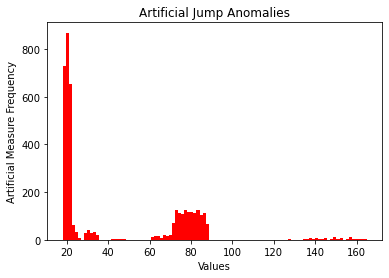

In [ ]:
plt.figure()
plt.hist(dataexplore["value"], bins=100,color="red")
plt.title("Artificial Jump Anomalies")
plt.xlabel("Values")
plt.ylabel("Artificial Measure Frequency")
plt.show()

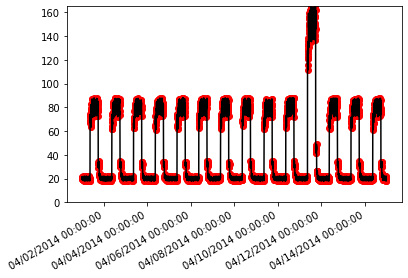

In [ ]:
#https://pretagteam.com/question/formatting-of-dates-in-python-with-matplotlib-and-datetime-x-axis-error-float
#https://stackoverflow.com/questions/9627686/plotting-dates-on-the-x-axis-with-pythons-matplotlib/9627970

plt.figure()
x = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in dataexplore.loc[:,"timestamp"]]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.plot(x, dataexplore.loc[:,"value"],"ro")
plt.plot(x, dataexplore.loc[:,"value"],"k")
plt.ylim([0, max(dataexplore.loc[:,"value"])])
plt.gcf().autofmt_xdate()
plt.show()

## Dataset loading and training, validation and test sets splitting

Training and test sets split into two csv files (run only once): 67% vs 34%. First, We split according to the order of observation because of the dataset structure and the autoencoder architecture we are applying. Each full day information will be considered a single observation for the model training so It will be split into 144 columns (we have 12 observation of 5 minutes each hour so We would have 28 12h samples). Then, we will perform a LOOCV cross validation split for the training set because of the small size of the training sample (around 18), we have chosen to feed the algorithm with.

In [ ]:
dataexplore

,timestamp,value
timestamp,,
2014-04-01 00:00:00,2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,2014-04-01 00:20:00,20.187739
...,...,...
2014-04-14 23:35:00,2014-04-14 23:35:00,18.074649
2014-04-14 23:40:00,2014-04-14 23:40:00,21.002014
2014-04-14 23:45:00,2014-04-14 23:45:00,20.566713


In [ ]:
# import datetime

In [ ]:
# daysplit=0.5
# print(totcol)
# print(list(range(0,len(dataexplore),int(totcol))))
# # print(len(dataexplore.index.hour.unique())*len(dataexplore.index.minute.unique()))
# print(dataexplore.iloc[:,1].tolist())
# dataexplore.iloc[list(range(0,len(dataexplore),int(totcol))),:]

In [ ]:
dataexplore

,timestamp,value
timestamp,,
2014-04-01 00:00:00,2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,2014-04-01 00:20:00,20.187739
...,...,...
2014-04-14 23:35:00,2014-04-14 23:35:00,18.074649
2014-04-14 23:40:00,2014-04-14 23:40:00,21.002014
2014-04-14 23:45:00,2014-04-14 23:45:00,20.566713


In [ ]:
daysplit=0.5
# print(dataexplore.index.day)
# print(len(dataexplore.index.hour.unique())*len(dataexplore.index.minute.unique()))
totcol=len(dataexplore.index.hour.unique())*len(dataexplore.index.minute.unique())*daysplit#=288 datos diarios x daysplit
cl=dict()
ids=list()
for i in range(0,int(totcol)):
    idx="H"+str(i)+"-"+str(i+12)
    cl[idx]=dataexplore.iloc[list(range(i,len(dataexplore),int(totcol))),(dataexplore.shape[1]-1)].values.tolist()
data=pd.DataFrame(cl)
# print(data)
# for i in range(0,int(len(dataexplore)/(288*daysplit))):
#     dataexplore.iloc[range(int(i*288*daysplit),int(288*daysplit+i*288*daysplit)),:].transpose()

Int64Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
            ...
            14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
           dtype='int64', name='timestamp', length=4032)
288
         H0-12       H1-13       H2-14       H3-15       H4-16       H5-17  \
0    19.761252   20.500833   19.961641   21.490266   20.187739   19.923126   
1    80.086866   80.946370   72.008422   75.357481   72.309510   83.971745   
2    21.608617   20.163073   20.799838   21.312434   21.166164   21.530422   
3    79.571110   74.892690   73.834357   85.821751   86.926469   73.172994   
4    19.025922   20.116698   21.841919   18.358538   20.732200   21.849056   
5    81.689661   83.558957   84.078369   84.231164   82.515972   75.362435   
6    21.260733   19.436691   19.919826   21.862756   18.968688   20.885016   
7    79.559403   80.882115   81.439731   78.465404   85.313224   74.872860   
8    21.961537   20.600713   18.508477   20.024680   20.116652   20.057786   
9    83.211977   76.458864   76.184420

In [ ]:
# daysplit=0.5 #Set a daysplit so that daysplit%%hours==0

# hours=list(range(24))
# days=list(dataexplore.index.day.unique())

# for el in range(12):
#     cold[coln]
#     dataexplore.loc[(dataexplore.index.hour==el+12)|(dataexplore.index.hour==el),:]

# cold=dict()
# for day in days:
#     coln=list(range(len(hours)*daysplit))
#     cold[coln]=dataexplore.loc[(dataexplore.index.day==day)&(dataexplore.index.hour<=11),:]
#     cold[coln]=dataexplore.loc[(dataexplore.index.day==day)&(dataexplore.index.hour>=12),:]
    
# print(list(days))
# # days

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [ ]:
#Encoding or missing values needed? No so far
# len(dataexplore)

#En este caso no es necesario el escalado porque la variable es la misma.
# sc=StandardScaler()
# X_train[:,3:]=sc.fit_transform(X_train[:,3:])
# X_test[:,3:]=sc.transform(X_test[:,3:])

#Quedaría la división en conjunto de test y train:

ind_train=math.ceil(data.shape[0]*0.66)
data_train=data.iloc[0:ind_train+1,:]
data_test=data.iloc[(ind_train+1):data.shape[0],:]

# data_train.to_csv("data/train_art_daily_jumpsup.csv")
# data_test.to_csv("data/test_art_daily_jumpsup.csv")

Dataset loading class

In [ ]:
class CSVDataset(Dataset):
    def __init__(self, csvfile, datadir, transform=None, target_transform=None):
        self.dt=pd.read_csv(datadir+"/"+csvfile)
        print(self.dt)
        self.data=self.dt.iloc[:,1:self.dt.shape[1]]
        self.labels = self.dt.iloc[:,0]
        self.datadir = datadir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.data.iloc[idx, 1:]
        label = self.labels.iloc[idx, 0]
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label

Cross validation set splitting and loading as pytorch tensors

In [ ]:
batch_size=2

dataset_train = CSVDataset(
    csvfile="train_art_daily_jumpsup.csv",
    datadir="data",
    transform=ToTensor())

dataset_test = CSVDataset(
    csvfile="test_art_daily_jumpsup.csv",
    datadir="data",
    transform=ToTensor())


#NO LO UTILIZO PORQUE NO TENGO ANOMALÍAS ETIQUETADAS

train=len(dataset_train)
test=len(dataset_test)
traincv=list()
testcv=list()
k=train-1

splits=KFold(n_splits=k,shuffle=True)

for fold,(idtrain,idtest) in enumerate(splits.split(np.arange(len(train)))):
    traincv.append(DataLoader(dataset_train, batch_size=batch_size, sampler=SubsetRandomSampler(idtrain)))
    testcv.append(DataLoader(dataset_train, batch_size=batch_size, sampler=SubsetRandomSampler(idtest)))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# trainloaded = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(idtrain))

                timestamp      value
0     2014-04-01 00:00:00  19.761252
1     2014-04-01 00:05:00  20.500833
2     2014-04-01 00:10:00  19.961641
3     2014-04-01 00:15:00  21.490266
4     2014-04-01 00:20:00  20.187739
...                   ...        ...
4027  2014-04-14 23:35:00  18.074649
4028  2014-04-14 23:40:00  21.002014
4029  2014-04-14 23:45:00  20.566713
4030  2014-04-14 23:50:00  18.254193
4031  2014-04-14 23:55:00  21.863147

[4032 rows x 2 columns]


In [ ]:
# class LSTMTagger(torch.nn.Module):

#     def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
#         super(LSTMTagger, self).__init__()
#         self.hidden_dim = hidden_dim

#         self.word_embeddings = torch.nn.Embedding(vocab_size, embedding_dim)

#         # The LSTM takes word embeddings as inputs, and outputs hidden states
#         # with dimensionality hidden_dim.
#         self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim)

#         # The linear layer that maps from hidden state space to tag space
#         self.hidden2tag = torch.nn.Linear(hidden_dim, tagset_size)

#     def forward(self, sentence):
#         embeds = self.word_embeddings(sentence)
#         lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
#         tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
#         tag_scores = F.log_softmax(tag_space, dim=1)
#         return tag_scores

In [ ]:
class Autoencoder(torch.nn.Module):
    def __init__(self, **kwargs):
        
        #input_shape
        #e_hidden_sizes
        #d_hidden_sizes
        
        super().__init__()
        
        self.size=len(kwargs["e_hidden_sizes"])+len(kwargs["d_hidden_sizes"])
        
        self.encolst=list()
        
        for i in range(len(kwargs["e_hidden_sizes"])):
            
            if i==0:
                inputs=kwargs["input_size"]
                outputs=kwargs["e_hidden_sizes"][i+1]
            
            elif i==(len(kwargs["e_hidden_sizes"])-1):
                inputs=kwargs["e_hidden_sizes"][i]
                outputs=kwargs["d_hidden_sizes"][0]
                
            else:
                inputs=kwargs["e_hidden_sizes"][i]
                outputs=kwargs["e_hidden_sizes"][i+1]
                
            self.encolst.append(nn.Linear(
                in_features=inputs, out_features=outputs
            ))

        decolst=list()
        
        for i in range(len(kwargs["d_hidden_sizes"])):
            
            if i==0:
                inputs=kwargs["e_hidden_sizes"][len(kwargs["e_hidden_sizes"])-1]
                outputs=kwargs["d_hidden_sizes"][i]
            
            elif i==(len(kwargs["d_hidden_sizes"])-1):
                inputs=kwargs["d_hidden_sizes"][i]
                outputs=kwargs["input_size"]
                
            else:
                inputs=kwargs["d_hidden_sizes"][i]
                outputs=kwargs["d_hidden_sizes"][i+1]
                
            self.decolst.append(nn.Linear(
                in_features=inputs, out_features=outputs
            ))

    def forward(self, x):
        for i in range(len(self.encolst)):
            x = self.encolst[i](x)
            x = torch.relu(x)
        for i in range(len(self.decolst)):
            x = self.decolst[i](x)
            x = torch.relu(x)
        return x

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

dummy_outputs = torch.rand(4, 10)
dummy_labels = torch.tensor([1, 5, 3, 7])
    

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        
        # Make predictions for this batch
        outputs = model(inputs)
        
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()
        
        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
            
    return last_loss

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)
    
    # We don't need gradients on to do reporting
    model.train(False)
    
    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
    
    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    
    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
    
    epoch_number += 1